$$ \Large{\textbf{open source Spectrum Analyser with Python}} $$
$$ \small{\textbf{Digital Signal Processing }} $$   


$$ \small{\textbf{Dr. Stéphane DEDIEU, January 2024}} $$

# Introduction

<span style="color:#4169E1">  Open source audio signal analyzer with Python. For quick lab tests. 
<br>
This program: <br>
    - downloads recording from sound calibrator (94 dBSPL)  ".wav" file <br>
    - downloads multiple measurement recordings  ".wav" files <br>
    - computes audio signals power in the time and frequency domain, dB SPL, dBA. <br>
    - compute the magnitude of the spectrum and display the results. 
<br>  
    
<span style="color:#4169E1"> Note: Initial source Matlab, from 2007-2009. 

#  Methodology
<br>
<span style="color:#4169E1"> 
Since we plot the magnitude of the spectrums and compute levels in dB SPL or dBA, we will use the pwelch function, based on the periodogram.  <br>
    - In this method, a nfft-long window slides on the signal. FFT magnitude is averaged.  <br>
    - A few seconds recordings are required: 3 to 5 seconds are sufficient. <br>
    - No Silence is allowed in recordings otherwise the estimation of levels in dBSPL or dBA will be wrong.    <br>
    
<b>The analyzer is not suited for measuring spectrum phases. We will implement an option:  Transfer Function if necessary. </b>

#  Importing librairies for Audio and DSP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import pylab
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import librosa    
import glob

In [2]:
import os
import pywt
#from wavelets.wave_python.waveletFunctions import *
import itertools
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

In [3]:
from scipy import signal
from scipy.signal import lfilter 

In [4]:
from playsound import playsound

## Parameters for spectrum analysis

In [188]:
# Frequency sampling
FS=16000;   #  16 kHz for measurements up to 8000 Hz. 
            #  48 kHz for measurements up to 20000 Hz. 
    

nfft=1024*2; # Number of bins for the FFT or Pwelch. In general 2048, 4096 points  
nfft=1024*16; # Number of bins for the FFT or Pwelch. In general 2048, 4096 points        
nfft=1024*32; # Number of bins for the FFT or Pwelch. In general 2048, 4096 points   


# Level Sound Calibrator in dB SPL 
level_calibrator=94; # in general 94 dBSPL. Some calibrators deliver 114 dBSPL !!!   


## Import Audio Recordings 

### Import Calibrator Audio 

All recordings will be resampled at sr=FS defined in "parameters"

In [189]:
ycalib, fs = librosa.load('C:/Users/drste/Demo_MircomII/Calibration.wav', sr=FS) # sample or resample at FS

# CHANGE THE PATH when running at MIRCOM !  

### Import all Units Audio Recordings 

In [190]:
file_names = []
data = []

#for filepath in glob.iglob('/Demo_Mircom'):
#       classes.append(filepath[8:])

for j in glob.iglob('C:/Users/drste/Demo_MircomII/Sample*.wav'): # CHANGE THE PATH HERE !   

        y, fs = librosa.load(j, sr=FS) # sample at FS     
        
        file_names.append(j[29:35])
        data.append(y)                #  

        print(j)

C:/Users/drste/Demo_MircomII\Sample - FH-LF - grill - new spkr.wav


In [191]:
file_names

['Sample']

In [192]:
audio_data=np.array(data,dtype=object)

In [193]:
np.shape(audio_data)

(1, 135920)

#### Listening to recordings

In [194]:
from IPython.display import Audio

Audio(data=audio_data[0], rate=FS)   # recording unit number 1


In [195]:
Audio(data=ycalib, rate=FS)         # recording calibrator 1kHz, 94 dBSPL

In [196]:
# we select 2 seconds of signal 
tim=2; # 2 seconds           
time_vector=(1/FS)*np.arange(tim*FS)  # time (s) vector 

In [197]:
ind=[0, 0, 0]

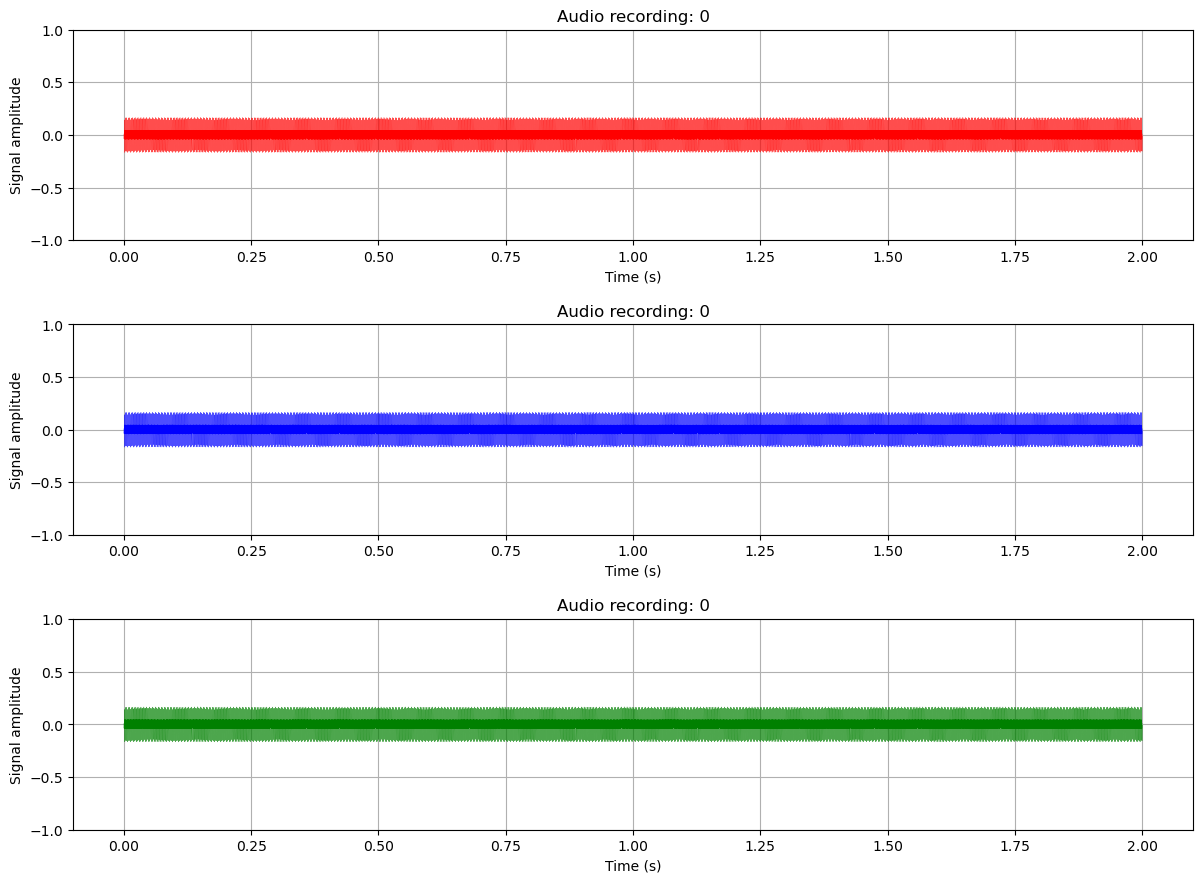

In [198]:
fig=plt.figure(figsize=(14,10))


ax = fig.add_subplot(3, 1, 1)
#  RGBA tuple  ((0,1,0,1))    Alpha is ytransparecy from 0 to 1   
plt.plot(time_vector,audio_data[ind[0]][0:len(time_vector)],'r',linewidth=0.25)
#plt.plot(time_vector,audio_data[ind[0]],'r',linewidth=0.25)
ax.set_ylim(-1, 1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal amplitude')
plt.title('Audio recording: '+str(ind[1])  )
ax.grid()
#plt.show()

ax = fig.add_subplot(3, 1, 2)
#  RGBA tuple  ((0,1,0,1))    Alpha is ytransparecy from 0 to 1   
plt.plot(time_vector,audio_data[ind[1]][0:len(time_vector)],'b',linewidth=0.25)
#plt.plot(time_vector,audio_data[ind[1]],'b',linewidth=0.25)
ax.set_ylim(-1, 1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal amplitude')
plt.title('Audio recording: '+str(ind[2])  )

ax.grid()

ax = fig.add_subplot(3, 1, 3)
#  RGBA tuple  ((0,1,0,1))    Alpha is ytransparecy from 0 to 1   
plt.plot(time_vector,audio_data[ind[2]][0:len(time_vector)],'g',linewidth=0.25)
#plt.plot(time_vector,audio_data[ind[2]],'g',linewidth=0.25)
ax.set_ylim(-1, 1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal amplitude')
plt.title('Audio recording: '+str(ind[2])  )
ax.grid()

# set the spacing between subplots
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

###### !pip install -U pygame
!pip install pygame

## Calibration Signal Analysis 

In [199]:
FS

16000

In [200]:
# use spectrum here. Not "density"
#frequencies, Pxx_spec = signal.welch(ycalib, FS, 'hann', nfft, 100, nfft, scaling='spectrum') 
frequencies, Pxx_spec = signal.welch(ycalib, FS, 'blackmanharris', nfft, 100, nfft, scaling='spectrum') 

In [201]:
frequencies

array([0.00000000e+00, 4.88281250e-01, 9.76562500e-01, ...,
       7.99902344e+03, 7.99951172e+03, 8.00000000e+03])

In [202]:
# Signal Average Power -  Will be useed for computing dBSPL, dBA of Units under Test                        
# here it is computed in the time domain 

avpower94dB= np.sum(np.abs(ycalib)**2)/len(ycalib);  # Average Power Calibrator Signal (referred sometimes as Total "RMS" Power)


####  Plotting the calibrator signal spectrum

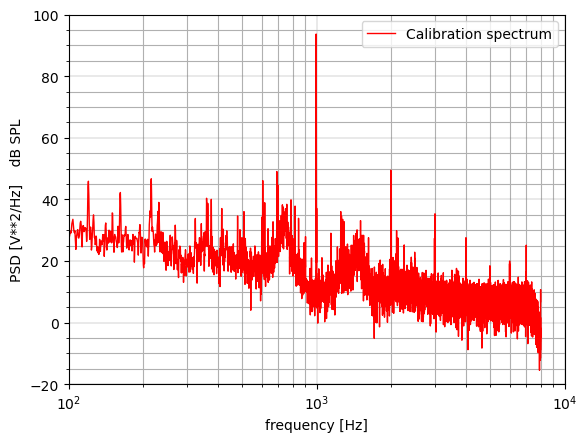

In [203]:
 # This is the simple formula for converting any signal power into dBSPL 

plt.semilogx(frequencies, 10*np.log10(Pxx_spec) - 10*np.log10(avpower94dB) + 94, 
                            label='Calibration spectrum',
                            color='red', 
                            linewidth=1)
plt.ylim([-20, 100])
plt.xlim([100, 10000])
plt.minorticks_on()
plt.grid(True, 'both', axis='both')
plt.grid(color='gray', linestyle='-', linewidth=0.25)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]    dB SPL')
plt.legend(loc='upper right')
plt.show()

#### A-weighting filter

<span style="color:#4169E1">  We define the A-weigthing filter after the vector "frequencies" defined with the calibration spectrum. (based on nfft) 
If the parameter nfft changes,  the filter must be recomputed. 

In [204]:
#========================
#   A -weighting Filter 
#========================       
Freq2=frequencies;
           #--------------------------------------------------------------------------------------
           #    " Definition here is ANSI A-Weighting Filter 
           #    The A-weighting filter is standardised in the ANSI document S1.4, 
           #    together with B- and C-weighting filters. They are described there 
           #    as pole-zero specifications which lead to this equation
           #    for the frequency response of the A-filter:
AWEIGHT_num=(3.5041384e16*Freq2**8);   
AWEIGHT_den=((20.598997**2+Freq2**2)**2)*(107.65265**2+Freq2**2)*(737.86223**2+Freq2**2)*(12194.217**2+Freq2**2)**2;
           #    (Note: This equation is not, as usual, based on the angular frequency  but directly
           #    on the frequency  in Hz.)"       
           #    ATTENTION:  AWEIGHT (Magnitude ^2 ~ Power)   A= 10*log10(AWEIGHT)              
           #---------------------------------------------------------------------------------------
AWEIGHT=np.divide(AWEIGHT_num,AWEIGHT_den); 

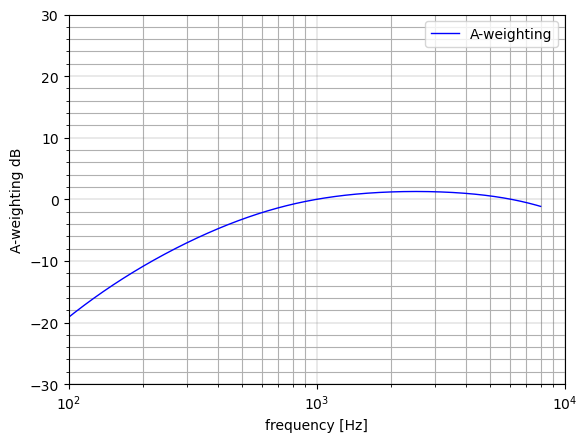

In [205]:
plt.semilogx(frequencies, 10*np.log10(AWEIGHT +1e-8),  #  epsilon= 1e-8 for preventing log10(0)
                            label='A-weighting',
                            color='blue', 
                            linewidth=1)
plt.ylim([-30, 30])
plt.xlim([100, 10000])
plt.minorticks_on()
plt.grid(True, 'both', axis='both')
plt.grid(color='gray', linestyle='-', linewidth=0.25)
plt.xlabel('frequency [Hz]')
plt.ylabel('A-weighting dB')
plt.legend(loc='upper right')
plt.show()

##### Calibration spectrum with A weighting filter

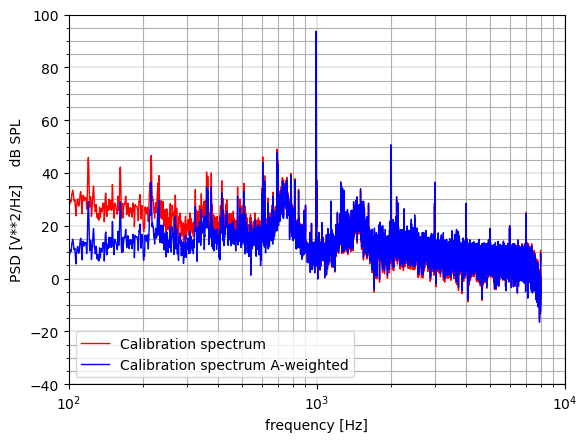

In [206]:
plt.semilogx(frequencies, 10*np.log10(Pxx_spec) - 10*np.log10(avpower94dB) + 94,  # conversion dBSPL 
                            label='Calibration spectrum',
                            color='red', 
                            linewidth=1)

plt.semilogx(frequencies, 10*np.log10(Pxx_spec) +  10*np.log10(AWEIGHT +1e-8) - 10*np.log10(avpower94dB) + 94,  # conversion dBSPL 
                            label='Calibration spectrum A-weighted',
                            color='blue', 
                            linewidth=1)


plt.ylim([-40, 100])
plt.xlim([100, 10000])
plt.minorticks_on()
plt.grid(True, 'both', axis='both')
plt.grid(color='gray', linestyle='-', linewidth=0.25)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]    dB SPL')
plt.legend(loc='lower left')
plt.show()


## Units Signal Analysis 

<span style="color:#4169E1">  We found recordings of miniature speakers aka "units". White Noise input. Measurements at 25 cm. 
These recordings are solely for illustration purposes. 
We compute the spectrum of all recordings (number is len(files_name)=3 in this example). 

#### Computation of power in each units time signal

In [207]:
average_power_units=[]
units_time_dBSPL=[]

for ii in range(len(file_names)):

    #avpwr= np.sum(np.abs(audio_data[ii])**2)/len(audio_data[ii]);  # Average Power units Signal (referred sometimes as Total "RMS" Power)
    avpwr= np.dot(audio_data[ii],audio_data[ii])/len(audio_data[ii]);  # Average Power units Signal (referred sometimes as Total "RMS" Power)
      
    
    dBSPL= 10*np.log10(avpwr) - 10*np.log10(avpower94dB) + 94;   
    
    units_time_dBSPL.append(dBSPL)
    average_power_units.append(avpwr)
    
    

In [208]:
len(audio_data[0])

135920

In [209]:
average_power_units =np.array(average_power_units) 
average_power_units.shape
units_time_dBSPL=np.array(units_time_dBSPL)
units_time_dBSPL.shape

(1,)

#### Computation of the spectrum magnitude of all units. 

In [210]:
Pxx_units= []   # spectrums of all units will be stored in this array. 


for ii in range(len(file_names)):
    
    #f, Pxx = signal.welch(audio_data[ii], FS, 'blackman',nfft, scaling='spectrum') # use spectrum here. Never "density' !!! "
    #f, Pxx = signal.welch(audio_data[ii], FS, 'hann',nfft,100, nfft, scaling='spectrum') # use spectrum here. Never "density' !!! "
    f, Pxx = signal.welch(audio_data[ii], FS, 'blackmanharris',nfft,nfft/2, nfft, scaling='spectrum') # use spectrum here. Never "density' !!! "
  
    #  NOTE:  nfft/2 before "scaling" should be 50% overlap 
    
    
    Pxx_units.append(Pxx);


In [211]:
Pxx_units =np.array(Pxx_units) 

Pxx_units=abs(Pxx_units).astype(float) #  Pxx is real positive.
                                    # we take abs because Pxx can be complex with a 0 imaginary part: x +i*0   
Pxx_units.shape

(1, 16385)

In [212]:
Pxx_units[0]

array([1.07205959e-11, 3.29294903e-11, 1.82523942e-10, ...,
       1.22692632e-12, 3.97272267e-12, 2.93323342e-12])

In [213]:
10*np.log10(np.abs(Pxx_units[0][:])+1e-9)

array([-89.95368884, -89.85929323, -89.27190058, ..., -89.99467479,
       -89.98278087, -89.98727978])

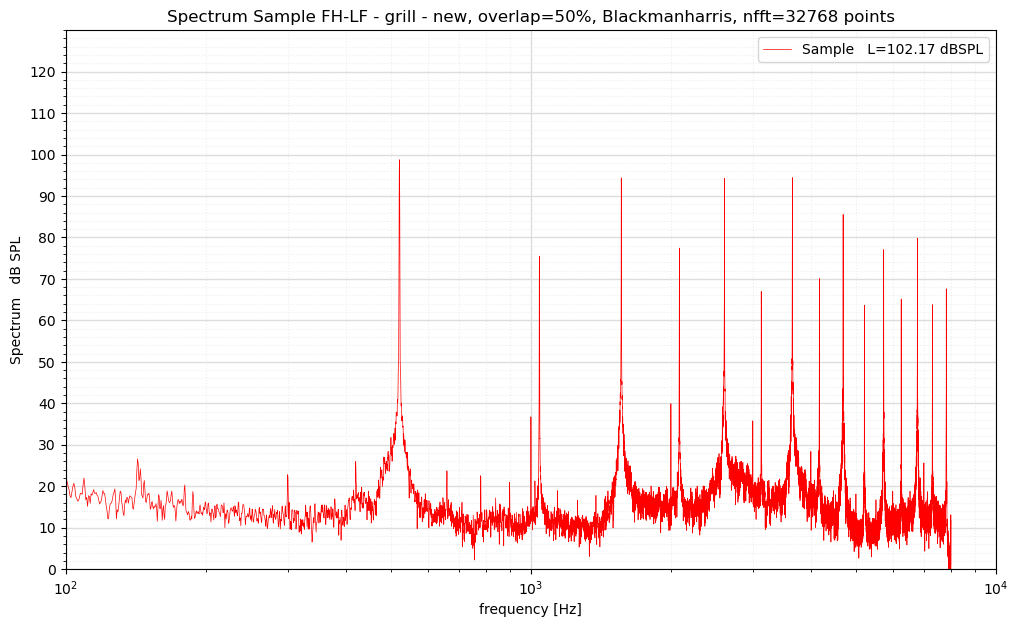

In [214]:


plt.figure(figsize=(12,7)) # In this example, all the plots will be in one figure.   

for ij in range(len(file_names)):
    
   # ydB= round(units_time_dBSPL[ij],2)
  #  plt.semilogx(frequencies, 10*np.log10(np.abs(Pxx_units[ij][:])) - 10*np.log10(avpower94dB) + 94,  #we introduce the dBSPL calibration here
  #                           label=file_names[ij]+'   L='+str(ydB)+' dBSPL')

    ydB= round(units_time_dBSPL[ij],2)
    plt.semilogx(frequencies, 10*np.log10(Pxx_units[ij][:]) - 10*np.log10(avpower94dB) + 94,  #we introduce the dBSPL calibration here                
                              linewidth=0.5,
                              color='r',
                              label=file_names[ij]+'   L='+str(ydB)+' dBSPL')

miny=0
    
plt.legend(loc='upper right')    
plt.ylim([miny, 130])

minor_ticks = np.arange(miny, 130, 1)
major_ticks = np.arange(miny, 130, 10)
plt.yticks(major_ticks)
plt.yticks(minor_ticks, minor=True)


plt.xlim([100, 10000])
plt.grid(True, 'both', axis='both')

plt.minorticks_on()

plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.8)
plt.grid(which='major', color='#DDDDDD', linewidth=1)
#plt.grid(color='gray', linestyle='-', linewidth=0.25)
plt.xlabel('frequency [Hz]')
plt.ylabel('Spectrum   dB SPL')

plt.title('Spectrum Sample FH-LF - grill - new, overlap=50%, Blackmanharris, nfft='+str(nfft)+' points')

plt.show()

<span style="color:#4169E1"> Unit_00# can be replaced with LF sounders White Noise measurement or Harmonics measurements.<br>
With the proper calibration formula, we will be able to read harmonics dB SPL on the graph. <br>
And by defining proper frequency intervals [490, 550], [1520, 1600], [2560,2640], [3600,3700] and searching the spectrum maximum in each interval, we can automatically detect F1, F3, F5, F7 and determine their SPL.  

#### Computing average power in the frequency domain

<span style="color:#4169E1"> If we want to compute the level dBA, using the A-weigthing formula defined in the frequency domain, we must work with the spectrums.   <br>
We first compute average power in dBSPL and make sure it is identical to the one computed in the time domain.(Parseval's theorem relative to Fourier transform). 

From Wikipedia: https://en.wikipedia.org/wiki/Parseval%27s_theorem

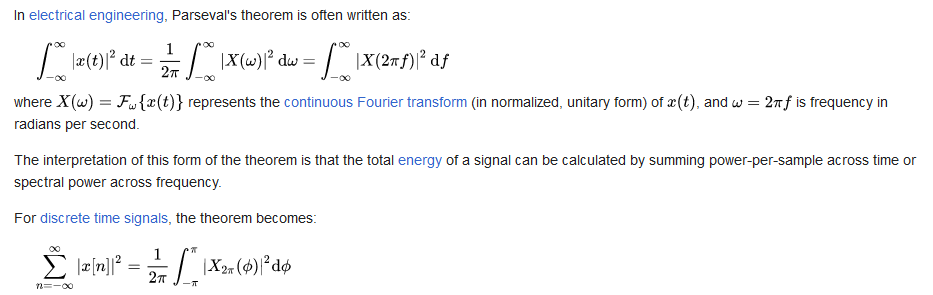

<span style="color:#4169E1">  Av power in the frequency domain. We can compute an integral over the spectrum. 
we try a trapezoid method.
Note that the detailed expression of Pxx in Python is not provided. Contrarily to Matlab.    
Since we work with half the spectrum, we should multiply Pxx by 2. Unless all FFT power was allocated to half the spectrum. 
There can either be a factor 2pi or pi and df included in Pxx.     

In [178]:
import scipy; 
df=frequencies[2]-frequencies[1];

ik=0;

Freq_avpower= (2/(np.pi) )*(1/df)*np.trapz(Pxx_units[ik],frequencies); 
#Freq_avpower=(2/(np.pi) )*(1/df)*scipy.integrate.simpson(Pxx_units[ik],frequencies)

Freq_avpower_A= (2/(np.pi) )*(1/df)*np.trapz(Pxx_units[ik]*AWEIGHT ,frequencies); 


freq_power_dBSPL= 10*np.log10(Freq_avpower)    -10*np.log10(avpower94dB)  +  94  ; 
freq_power_dBA=   10*np.log10(Freq_avpower_A)  -10*np.log10(avpower94dB)  +  94  ; 


ydBspl_time= round(units_time_dBSPL[ik],2)


print(file_names[ik])
print('SPL time domain:',  ydBspl_time)
print('SPL freq domain:', round(freq_power_dBSPL,2)) 
print('dbA freq domain:', round(freq_power_dBA,2))

Sample
SPL time domain: 102.17
SPL freq domain: 103.23
dbA freq domain: 102.9


	Matlab results unit_001
    
    nfft=2048
    |================================================|
	|	Acoustic levels                          |
	|================================================|

	| White Noise SPL (time domain)	                 |     73.72	   |  dBSPL |
	| White Noise SPL (freq domain)	                 |     73.75	   |  dBSPL |
	| White Noise SPL (freq domain - A weighted)	 |     73.95	   |  dBA   |

	|================================================|
    
    nfft=4096
    |================================================|
	|	Acoustic levels                          |
	|================================================|

	| White Noise SPL (time domain)	                 |     73.72	   |  dBSPL |
	| White Noise SPL (freq domain)	                 |     73.71	   |  dBSPL |
	| White Noise SPL (freq domain - A weighted)	 |     73.91	   |  dBA   |

	|================================================|
    
    